<a href="https://colab.research.google.com/github/Risuo/Springboard/blob/master/Google_Quick_Sketch_Optimize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from google.colab import files
import distutils
import os
if distutils.version.LooseVersion(tf.__version__) < '1.14':
  raise Exception ('No go, use Tensorflow 1.14 or newer')

In [0]:
%whos

Variable    Type               Data/Info
----------------------------------------
distutils   module             <module 'distutils' from <...>6/distutils/__init__.py'>
drive       module             <module 'google.colab.dri<...>s/google/colab/drive.py'>
files       module             <module 'google.colab.fil<...>s/google/colab/files.py'>
keras       TFModuleWrapper    <module 'tensorflow.pytho<...>i/_v1/keras/__init__.py'>
np          module             <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
os          module             <module 'os' from '/usr/lib/python3.6/os.py'>
tf          TFModuleWrapper    <module 'tensorflow' from<...>/tensorflow/__init__.py'>


In [0]:
class_names = np.load('/content/drive/My Drive/Springboard era ML AI/Quick Draw Doodle Project/class_names.npy')

In [0]:
x_train = np.load('/content/drive/My Drive/Springboard era ML AI/Quick Draw Doodle Project/Quarter-Size Datasets/x_train_q.npy')

In [0]:
y_train = np.load('/content/drive/My Drive/Springboard era ML AI/Quick Draw Doodle Project/Quarter-Size Datasets/y_train_q.npy')

In [0]:
x_test = np.load('/content/drive/My Drive/Springboard era ML AI/Quick Draw Doodle Project/Quarter-Size Datasets/x_test_q.npy')

In [0]:
y_test = np.load('/content/drive/My Drive/Springboard era ML AI/Quick Draw Doodle Project/Quarter-Size Datasets/y_test_q.npy')

In [0]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
num_classes = len(class_names)
print(num_classes)

(1656000, 28, 28, 1)
(1656000, 345)
(414000, 28, 28, 1)
(414000, 345)
345


In [0]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [0]:
x_train /= 255.0
x_test /= 255.0

In [0]:
x_train_l = x_train[:1606000]
y_train_l = y_train[:1606000]

#x_test_s = x_test[:10000]
#y_test_s = y_test[:10000]

x_val = x_train[-50000:]
y_val = y_train[-50000:]

In [0]:
print(x_train_s.shape)
print(y_train_s.shape)

print(x_test_s.shape)
print(y_test_s.shape)

print(x_val.shape)
print(y_val.shape)


(60000, 28, 28, 1)
(60000, 345)
(10000, 28, 28, 1)
(10000, 345)
(5000, 28, 28, 1)
(5000, 345)


In [0]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, BatchNormalization
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.models import load_model 
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
!pip install h5py scikit-optimize

     |████████████████████████████████| 81kB 2.0MB/s 


In [0]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [0]:
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)
print('Scikit optimize version:', skopt.__version__)

Tensorflow version: 1.15.0
Keras version: 2.2.4-tf


NameError: ignored

In [0]:
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, kernel_size, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./doodle_GPU_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       kernel_size,
                       activation)

    return log_dir

In [0]:
dim_learning_rate = Real(low = 1e-6, 
                         high = 1e-2, 
                         prior = 'log-uniform',
                         name = 'learning_rate')

dim_num_dense_layers = Integer(low = 1,
                               high = 8,
                               name = 'num_dense_layers')

dim_num_dense_nodes = Integer(low = 5,
                              high = 1024,
                              name = 'num_dense_nodes')

dim_kernel_size = Integer(low = 1,
                          high = 4,
                          name = 'kernel_size')

dim_activation = Categorical(categories = ['relu', 'sigmoid', 'elu'],
                             name = 'activation')





In [0]:
dim_learning_rate = Real(low = 1e-6, 
                         high = 1e-2, 
                         prior = 'log-uniform',
                         name = 'learning_rate')

In [0]:
dim_num_dense_layers = Integer(low = 1,
                               high = 8,
                               name = 'num_dense_layers')

In [0]:
dim_num_dense_nodes = Integer(low = 5,
                              high = 1024,
                              name = 'num_dense_nodes')

In [0]:
dim_kernel_size = Integer(low = 1,
                          high = 4,
                          name = 'kernel_size')

In [0]:
#dim_stride_length = Integer(low = 1,
#                     high = 1,
#                     name = 'stride_length')

In [0]:
dim_activation = Categorical(categories = ['relu', 'sigmoid', 'elu'],
                             name = 'activation')

In [0]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_kernel_size,
              dim_activation]

In [0]:
default_parameters = [1e-3, 1, 350, 3, 'relu']

In [0]:
validation_data = (x_val, y_val)

In [0]:
img_size = 28

img_size_flat = img_size * img_size

img_shape = (img_size, img_size)

img_shape_full = (img_size, img_size, 1)

num_channels = 1

num_classes = 345

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

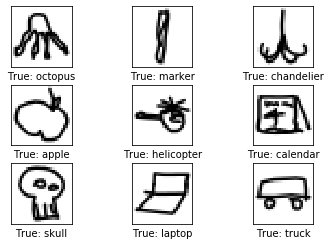

In [0]:
# Get the first images from the test-set.
images = x_test[0:9]

# Get the true classes for those images.

cls_true = class_names[(np.argmax(y_test, axis = 1)[0:9])]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [0]:
def create_model():
  model = Sequential()
  model.add(Conv2D(kernel_size=(4,4), strides=1, filters=16, padding='same', input_shape = x_train.shape[1:], activation='elu'))
  model.add(MaxPooling2D(pool_size=2, strides=2))
  model.add(Conv2D(kernel_size=(4,4), strides=1, filters=32, padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=2, strides=2))  
  model.add(Conv2D(kernel_size=(4,4), strides=1, filters=64, padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=2, strides=2))
  model.add(Conv2D(kernel_size=(4,4), strides=1, filters=128, padding='same', activation='elu'))
  model.add(MaxPooling2D(pool_size=2, strides=2))
  model.add(Flatten())
  model.add(Dense(822, activation = 'elu'))
  model.add(Dense(345, activation='softmax'))
  return model


In [0]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, kernel_size, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    kernel_size:       Kernel Size of each conv2D layer.
    activation:        Activation function for all layers.
    """

    # Start construction of a Keras Sequential model.
    model = Sequential()

    # Add an input layer which is similar to a feed_dict in TensorFlow.
    # Note that the input-shape must be a tuple containing the image-size.
    #model.add(InputLayer(input_shape=(img_size_flat,)))

    # The input from MNIST is a flattened array with 784 elements,
    # but the convolutional layers expect images with shape (28, 28, 1)
    #model.add(Reshape(img_shape_full))

    # First convolutional layer.
    # There are many hyper-parameters in this layer, but we only
    # want to optimize the activation-function in this example.
    model.add(Conv2D(kernel_size=(kernel_size,kernel_size), strides=1, filters=16, padding='same',
                     input_shape = x_train_s.shape[1:],
                     activation=activation, name='layer_conv1'))
    model.add(MaxPooling2D(pool_size=2, strides=2))

    # Second convolutional layer.
    # Again, we only want to optimize the activation-function here.
    model.add(Conv2D(kernel_size=(kernel_size,kernel_size), strides=1, filters=32, padding='same',
                     activation=activation, name='layer_conv2'))
    model.add(MaxPooling2D(pool_size=2, strides=2))
      
    # Third convolutional layer.
    # Again, we only want to optimize the activation-function here.
    model.add(Conv2D(kernel_size=(kernel_size,kernel_size), strides=1, filters=64, padding='same',
                     activation=activation, name='layer_conv3'))
    model.add(MaxPooling2D(pool_size=2, strides=2))


    # Fourth convolutional layer.
    # Again, we only want to optimize the activation-function here.
    model.add(Conv2D(kernel_size=(kernel_size,kernel_size), strides=1, filters=128, padding='same',
                     activation=activation, name='layer_conv4'))
    model.add(MaxPooling2D(pool_size=2, strides=2))



    # Flatten the 4-rank output of the convolutional layers
    # to 2-rank that can be input to a fully-connected / dense layer.
    model.add(Flatten())

    # Add fully-connected / dense layers.
    # The number of layers is a hyper-parameter we want to optimize.
    for i in range(num_dense_layers):
        # Name of the layer. This is not really necessary
        # because Keras should give them unique names.
        name = 'layer_dense_{0}'.format(i+1)

        # Add the dense / fully-connected layer to the model.
        # This has two hyper-parameters we want to optimize:
        # The number of nodes and the activation function.
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))

    # Last fully-connected / dense layer with softmax-activation
    # for use in classification.
    model.add(Dense(num_classes, activation='softmax'))
    
    # Use the Adam method for training the network.
    # We want to find the best learning-rate for the Adam method.
    optimizer = Adam(lr=learning_rate)
    
    # In Keras we need to compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'top_k_categorical_accuracy'])
    
    return model

In [0]:
path_best_model_initial_optimize = 'best_model_initial_optimize.keras'

In [0]:
best_accuracy = 0.0

In [0]:
count = 0
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, kernel_size, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    kernel_size:       Kernel Size of each conv2D layer.
    activation:        Activation function for all layers.
    """

    global count 
    count += 1
    # Print the hyper-parameters.
    print('model #', count)
    print()
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('kernel_size:', kernel_size)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.

    

    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         kernel_size=kernel_size,
                         activation=activation)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, kernel_size, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x=x_train_s,
                        y=y_train_s,
                        epochs=3,
                        batch_size=128,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_acc'][-1]

    print(history.history)

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model_initial_optimize)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    
    return -accuracy

In [0]:
fitness(x=default_parameters)

model # 1

learning rate: 1.0e-03
num_dense_layers: 1
num_dense_nodes: 350
kernel_size: 3
activation: relu

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples, validate on 5000 samples
Epoch 1/3
60000/60000 [==============================] - 10s 162us/sample - loss: 4.6060 - acc: 0.0965 - top_k_categorical_accuracy: 0.2555 - val_loss: 3.8260 - val_acc: 0.1964 - val_top_k_categorical_accuracy: 0.4358
Epoch 2/3
60000/60000 [==============================] - 3s 51us/sample - loss: 3.3602 - acc: 0.2644 - top_k_categorical_accuracy: 0.5375 - val_loss: 3.2168 - val_acc: 0.2960 - val_top_k_categorical_accuracy: 0.5792
Epoch 3/3
60000/60000 [==============================] - 3s 52us/sample - loss: 2.8680 - acc: 0.3497 - top_k_categorical_accuracy: 0.6374 - val_loss: 2.9332 - val_acc: 0.3520 - val_top_k_categorical_accuracy: 0.6346
{'loss': [4.605981689453125, 3.3601747049967448, 2.867967830403646], 'acc': [0.09646667, 0.26441666, 0.34966666]

-0.352

In [0]:
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=50,
                            x0=default_parameters)

model # 2

learning rate: 1.0e-03
num_dense_layers: 1
num_dense_nodes: 350
kernel_size: 3
activation: relu

Train on 60000 samples, validate on 5000 samples
Epoch 1/3
60000/60000 [==============================] - 4s 58us/sample - loss: 4.5713 - acc: 0.1009 - top_k_categorical_accuracy: 0.2651 - val_loss: 3.8263 - val_acc: 0.1912 - val_top_k_categorical_accuracy: 0.4426
Epoch 2/3
60000/60000 [==============================] - 3s 55us/sample - loss: 3.3003 - acc: 0.2706 - top_k_categorical_accuracy: 0.5467 - val_loss: 3.1806 - val_acc: 0.3080 - val_top_k_categorical_accuracy: 0.5876
Epoch 3/3
60000/60000 [==============================] - 3s 53us/sample - loss: 2.7961 - acc: 0.3609 - top_k_categorical_accuracy: 0.6488 - val_loss: 2.9322 - val_acc: 0.3464 - val_top_k_categorical_accuracy: 0.6324
{'loss': [4.571343351109823, 3.300343951034546, 2.7961193756103517], 'acc': [0.1009, 0.27056667, 0.36086667], 'top_k_categorical_accuracy': [0.26508334, 0.5467333, 0.64881665], 'val_loss': [3.826

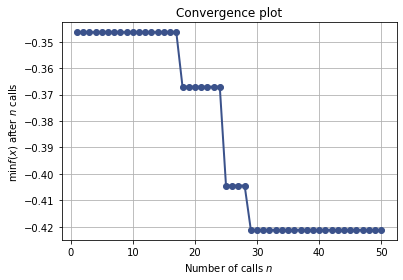

In [0]:
plot_convergence(search_result)

In [0]:
search_result.x

[0.0007388971256192591, 1, 822, 4, 'elu']

In [0]:
space = search_result.space

In [0]:
sorted(zip(search_result.func_vals, search_result.x_iters))[:10]

[(-0.4212, [0.0007388971256192591, 1, 822, 4, 'elu']),
 (-0.413, [0.0007642006383557408, 1, 765, 4, 'elu']),
 (-0.4118, [0.0007638635151699078, 1, 766, 4, 'elu']),
 (-0.4094, [0.0007700741156066329, 1, 763, 4, 'elu']),
 (-0.4086, [0.0007630284333570987, 1, 768, 4, 'elu']),
 (-0.4072, [0.0007940616729351839, 1, 707, 4, 'elu']),
 (-0.4068, [0.0007711168491671444, 1, 757, 4, 'elu']),
 (-0.4066, [0.0007638239117450621, 1, 767, 4, 'elu']),
 (-0.4044, [0.0006116231610317688, 1, 1024, 4, 'elu']),
 (-0.4034, [0.000776032360522664, 1, 723, 4, 'elu'])]

In [0]:
fitness(x=search_result.x)

model # 52

learning rate: 7.4e-04
num_dense_layers: 1
num_dense_nodes: 822
kernel_size: 4
activation: elu

Train on 60000 samples, validate on 5000 samples
Epoch 1/3
60000/60000 [==============================] - 4s 62us/sample - loss: 4.1774 - acc: 0.1561 - top_k_categorical_accuracy: 0.3599 - val_loss: 3.4076 - val_acc: 0.2712 - val_top_k_categorical_accuracy: 0.5398
Epoch 2/3
60000/60000 [==============================] - 3s 57us/sample - loss: 2.9249 - acc: 0.3423 - top_k_categorical_accuracy: 0.6287 - val_loss: 2.8910 - val_acc: 0.3676 - val_top_k_categorical_accuracy: 0.6438
Epoch 3/3
60000/60000 [==============================] - 3s 57us/sample - loss: 2.4772 - acc: 0.4271 - top_k_categorical_accuracy: 0.7116 - val_loss: 2.6740 - val_acc: 0.4002 - val_top_k_categorical_accuracy: 0.6802
{'loss': [4.177425531641642, 2.924867175801595, 2.477169783528646], 'acc': [0.15606667, 0.3423, 0.42708334], 'top_k_categorical_accuracy': [0.35991666, 0.62865, 0.7116], 'val_loss': [3.4075909088

-0.4002

In [0]:
model = load_model('/content/best_model_initial_optimize.keras')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
del model

In [0]:
model = create_model()

In [0]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.0007388971256192591),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', 'top_k_categorical_accuracy'])

In [0]:
untrained = model.evaluate(x = x_test,
                           y = y_test)

414000/414000 [==============================] - 29s 70us/sample - loss: 5.8443 - acc: 0.0030 - top_k_categorical_accuracy: 0.0127


In [0]:
model.fit(x_train_l, y_train_l,
          epochs=30,
          batch_size=5120,
          validation_data=(x_val, y_val))

Train on 1606000 samples, validate on 50000 samples
Epoch 1/30
1606000/1606000 [==============================] - 27s 17us/sample - loss: 3.4365 - acc: 0.2793 - top_k_categorical_accuracy: 0.5255 - val_loss: 2.6259 - val_acc: 0.4111 - val_top_k_categorical_accuracy: 0.6885
Epoch 2/30
1606000/1606000 [==============================] - 26s 16us/sample - loss: 2.3369 - acc: 0.4666 - top_k_categorical_accuracy: 0.7382 - val_loss: 2.1904 - val_acc: 0.4980 - val_top_k_categorical_accuracy: 0.7625
Epoch 3/30
1606000/1606000 [==============================] - 26s 16us/sample - loss: 2.0360 - acc: 0.5260 - top_k_categorical_accuracy: 0.7865 - val_loss: 1.9875 - val_acc: 0.5376 - val_top_k_categorical_accuracy: 0.7940
Epoch 4/30
1606000/1606000 [==============================] - 26s 16us/sample - loss: 1.8797 - acc: 0.5580 - top_k_categorical_accuracy: 0.8096 - val_loss: 1.8698 - val_acc: 0.5635 - val_top_k_categorical_accuracy: 0.8114
Epoch 5/30
1606000/1606000 [==============================] 

In [0]:
{'loss': [4.177425531641642, 2.924867175801595, 2.477169783528646], 'acc': [0.15606667, 0.3423, 0.42708334], 'top_k_categorical_accuracy': [0.35991666, 0.62865, 0.7116], 'val_loss': [3.4075909088134764, 2.8909639083862304, 2.673989165496826], 'val_acc': [0.2712, 0.3676, 0.4002], 'val_top_k_categorical_accuracy': [0.5398, 0.6438, 0.6802]}


In [0]:
del model

In [0]:
model = create_model()

In [0]:
model.compile(tf.keras.optimizers.Adam(learning_rate = 0.0007388971256192591),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy', 'top_k_categorical_accuracy'])




In [0]:
untrained = model.evaluate(x = x_test,
                           y = y_test)

414000/414000 [==============================] - 30s 73us/sample - loss: 5.8444 - acc: 0.0030 - top_k_categorical_accuracy: 0.0154


Train on 1324800 samples, validate on 331200 samples
Epoch 1/30
1324800/1324800 [==============================] - 28s 21us/sample - loss: 2.7965 - acc: 0.3844 - top_k_categorical_accuracy: 0.6475 - val_loss: 2.1224 - val_acc: 0.5084 - val_top_k_categorical_accuracy: 0.7732
Epoch 2/30
1324800/1324800 [==============================] - 28s 21us/sample - loss: 1.9428 - acc: 0.5422 - top_k_categorical_accuracy: 0.8004 - val_loss: 1.8440 - val_acc: 0.5650 - val_top_k_categorical_accuracy: 0.8150
Epoch 3/30
1324800/1324800 [==============================] - 28s 21us/sample - loss: 1.7319 - acc: 0.5862 - top_k_categorical_accuracy: 0.8307 - val_loss: 1.7125 - val_acc: 0.5914 - val_top_k_categorical_accuracy: 0.8336
Epoch 4/30
1324800/1324800 [==============================] - 28s 21us/sample - loss: 1.6173 - acc: 0.6099 - top_k_categorical_accuracy: 0.8464 - val_loss: 1.6450 - val_acc: 0.6056 - val_top_k_categorical_accuracy: 0.8423
Epoch 5/30
1324800/1324800 [==============================]

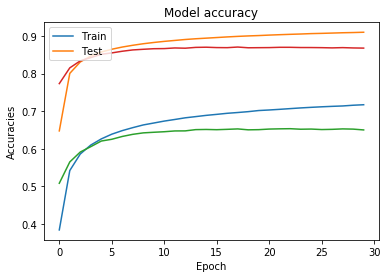

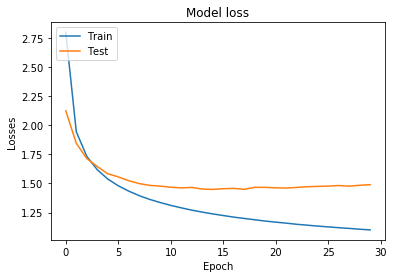

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

history = model.fit(x_train, y_train,
          epochs=30,
          batch_size=1280,
          validation_split = .2,
          verbose = 1)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['val_top_k_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracies')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


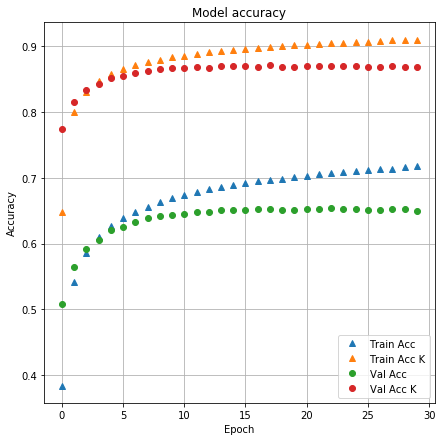

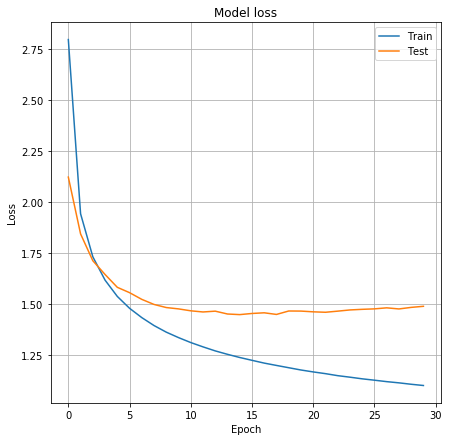

In [0]:
fig = plt.figure(figsize=(7,7))

plt.plot(history.history['acc'], '^')
plt.plot(history.history['top_k_categorical_accuracy'], '^')
plt.plot(history.history['val_acc'], 'o')
plt.plot(history.history['val_top_k_categorical_accuracy'], 'o')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train Acc', 'Train Acc K', 'Val Acc', 'Val Acc K'], loc='best')
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(7,7))
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.grid(True)
plt.show()

In [0]:
path_trained_best_model = 'trained_best_model.keras'

In [0]:
trained = model.evaluate(x = x_test,
                         y = y_test)

414000/414000 [==============================] - 29s 69us/sample - loss: 1.6024 - acc: 0.6186 - top_k_categorical_accuracy: 0.8479


In [0]:
model.save(path_trained_best_model)

In [0]:
with open('class_names.txt', 'w') as file_handler:
  for item in class_names:
    file_handler.write("{}\n".format(item))

In [0]:
!pip install tensorflowjs

     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 17.3MB 203kB/s 
     |████████████████████████████████| 81kB 15.3MB/s 
     |████████████████████████████████| 256kB 54.1MB/s 
     |████████████████████████████████| 901kB 69.7MB/s 
  Created wheel for PyInquirer: filename=PyInquirer-1.0.3-cp36-none-any.whl size=32853 sha256=02f1360280c14e9cbcf2ce9634f5ef0de98f636d33d44b21c36e589ec6b29cb1
  Stored in directory: /root/.cache/pip/wheels/52/6c/b1/3e4b0e8daf42a92883c7641c0ea8ffb62e0490ebed2faa55ad
Successfully built PyInquirer
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.17.5
    Uninstalling numpy-1.17.5:
      Successfully 

In [0]:
model.save('keras.h5')

In [0]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

mkdir: cannot create directory ‘model’: File exists


In [0]:
!cp class_names.txt model/class_names.txt

In [0]:
!zip -r model.zip model

updating: model/ (stored 0%)
updating: model/group1-shard1of1.bin (deflated 7%)
updating: model/class_names.txt (deflated 45%)
updating: model/model.json (deflated 84%)


In [0]:
from google.colab import files
files.download('model.zip')

In [0]:
model.save('./trained_model_optimized_quartersize_dataset_weights.h5', overwrite = True)

In [0]:
cpu_model_untrained = load_model('/content/best_model_initial_optimize.keras')
cpu_model_trained = load_model('/content/trained_best_model.keras')
#cpu_model.load_weights('/trained_model_optimized_quartersize_dataset_weights.h5')

from matplotlib import pyplot
%matplotlib inline

def plot_predictions(images, predictions):
  n = images.shape[0]
  nc = int(np.ceil(n/4))
  f, axes = pyplot.subplots(nc, 4)
  for i in range(nc * 4):
    y = i // 4
    x = i % 4
    axes[x, y].axis('off')

    label = class_names[np.argmax(predictions[i])]
    confidence = np.max(predictions[i])
    
    if i > n:
      continue
    axes[x, y].imshow(images[i])
    axes[x, y].text(.5, .5, label + '\n%.3f' % confidence, fontsize = 14)

  pyplot.gcf().set_size_inches(10,10)



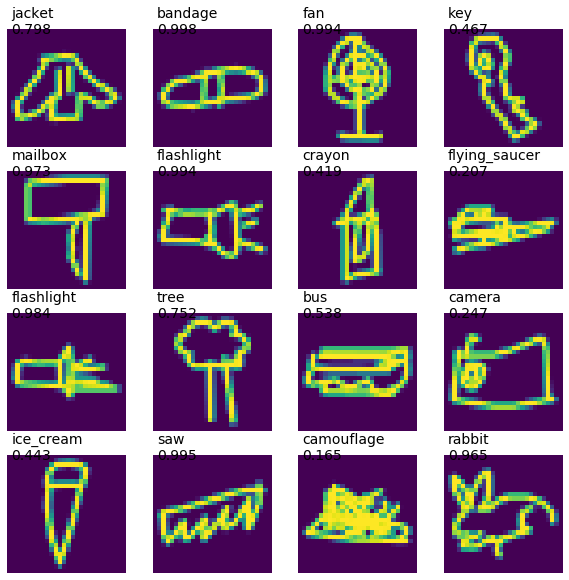

In [0]:
plot_predictions(np.squeeze(x_val[32:48]),
                 cpu_model_trained.predict(x_val[32:48]))

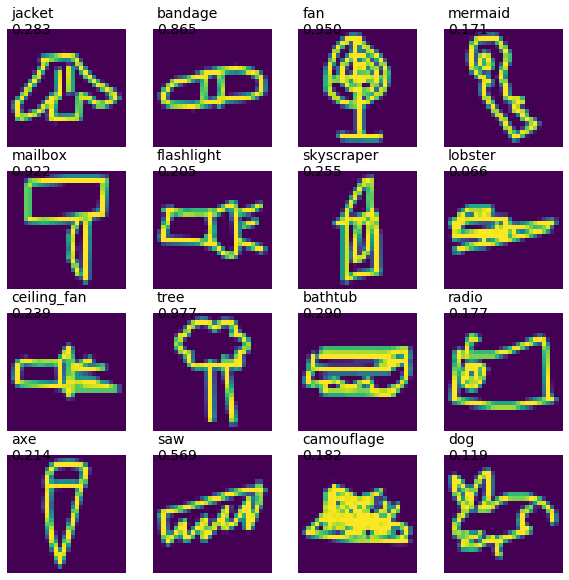

In [0]:
plot_predictions(np.squeeze(x_val[32:48]),
                 cpu_model_untrained.predict(x_val[32:48]))

In [0]:
with open('class_names.txt', 'w') as file_handler:
  for item in class_names:
    file_handler.write("{}\n".format(item))

In [0]:
!pip install tensorflowjs

In [0]:
model_trained_3_epochs = load_model('/content/drive/My Drive/Springboard era ML AI/Quick Draw Doodle Project/Model Examples/best_model_initial_optimize.keras')

NameError: ignored

In [0]:
model_trained_23_epochs = load_model('/content/drive/My Drive/Springboard era ML AI/Quick Draw Doodle Project/Model Examples/trained_best_model.keras')

In [0]:
!mkdir model3
!mkdir model23

In [0]:
model_trained_3_epochs.save('3_keras.h5')

In [0]:
model_trained_23_epochs.save('23_keras.h5')

In [0]:
!tensorflowjs_converter --input_format keras 3_keras.h5 model3/

In [0]:
!tensorflowjs_converter --input_format keras 23_keras.h5 model23/

In [0]:
!cp class_names.txt model3/class_names.txt
!cp class_names.txt model23/class_names.txt

In [0]:

!zip -r model23.zip model23

  adding: model3/ (stored 0%)
  adding: model3/group1-shard1of1.bin (deflated 8%)
  adding: model3/23_keras.h5 (deflated 9%)
  adding: model3/3_keras.h5 (deflated 9%)
  adding: model3/class_names.txt (deflated 45%)
  adding: model3/model.json (deflated 84%)
  adding: model23/ (stored 0%)
  adding: model23/group1-shard1of1.bin (deflated 7%)
  adding: model23/class_names.txt (deflated 45%)
  adding: model23/model.json (deflated 85%)


In [0]:
from google.colab import files
files.download('model3.zip')

In [0]:
from google.colab import files
files.download('model23.zip')